## Autoenkoder wariancyjny

Import potrzebnych bibliotek:

In [1]:
from tensorflow import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Wczytanie danych:
- `image size` - rozmiar obrazu, u nas 28
- `original_dim` - wymiar ,,spłaszczonego'' obrazu, u nas 28*28=784
- `x_train_data` i `x_test_data` mają zmieniany wymiar z 28x28 na 784 czyli są spłaszcane. Następuje konwersja na `float` i podzielenie przez 255 (w celu standaryzacji)
- `input_shape` = (784,)
- `batch_size` = 128

In [2]:
(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()
image_size = x_train_data.shape[1]
original_dim = image_size * image_size
x_train_data = np.reshape(x_train_data, [-1, original_dim])
x_test_data = np.reshape(x_test_data, [-1, original_dim])
x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255
input_shape = (original_dim, )
batch_size = 128

Funkcja `latent_sampling` do wykonania próbkowania w warstwie ukrytej

In [3]:
def latent_sampling(args):
    z_mean_layer, z_log_var_layer = args # z autoenkodera
    batch = K.shape(z_mean_layer)[0] # rozmiar pakietu
    dimension = K.int_shape(z_mean_layer)[1] # rozmiar kodowania ukrytego
    ep = K.random_normal(shape=(batch, dimension)) # losowanie z rozkl normalnego
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

In [4]:
def plot_vae_output(decoder,latent_dim):
    n = 5
    digit_num = 28
    figure = np.zeros((digit_num * n, digit_num * n))
    axis_x = np.linspace(-3, 3, n)
    axis_y = np.linspace(-3, 3, n)[::-1]    
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(latent_dim == 2):
                latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
            else:
                latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
            input_decoded = decoder.predict(latent_sample)
            digit = input_decoded[0].reshape(digit_num, digit_num)
            figure[i * digit_num: (i + 1) * digit_num,
                   j * digit_num: (j + 1) * digit_num] = digit
    
    plt.figure(figsize=(10, 10))
    i_range = digit_num // 2
    j_range = (n - 1) * digit_num + i_range + 1
    pixel_range = np.arange(i_range, j_range, digit_num)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    #plt.imshow(figure, cmap='Greens_r')
    plt.imshow(figure)
    plt.savefig("VAE_Output")
    plt.gray()

In [5]:
# hidden_node - wymiar w warstwie gestej
# latent_node - wymiar kodowan
hidden_node = 256
latent_node = 2
# model kodera
# warstwa wejsciowa
encoder_inputs = Input(shape=input_shape, name='input_encoder')
# warstwa gesta
encoder_hidden = Dense(hidden_node, activation='relu')(encoder_inputs)
# warstwa srednich i odchylen
z_mean = Dense(latent_node, name='z_mean')(encoder_hidden)
z_log_var = Dense(latent_node, name='z_log_var')(encoder_hidden)
# probkowanie w warstwie ukrytej
z = Lambda(latent_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])
# utworzenie modelu kodera:
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_encoder[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['dense[0][0]']                  
                                                                                            

In [6]:
# model dekodera
# warstwa wejsciowa
latent_decoder_inputs = Input(shape=(latent_node,), name='latent_sampling') # wejscie ma wymiar kodowania ukrytego
# warstwa gesta (wymiar jak w koderze w warstwie gestej)
decoder_hidden = Dense(hidden_node, activation='relu')(latent_decoder_inputs) 
# warstwa wyjsciowa (wymiar jak oryginaly wymiar)
decoder_outputs = Dense(original_dim, activation='sigmoid')(decoder_hidden)
# utworzenie modelu dekodera
decoder = Model(latent_decoder_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_sampling (InputLayer  [(None, 2)]              0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 256)               768       
                                                                 
 dense_2 (Dense)             (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [7]:
# utworzenie modelu VAE
model_outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, model_outputs, name='vae')
# funkcja straty rekonstrukcji (binarna entropia krzyzowa)
reconstruction_loss = binary_crossentropy(encoder_inputs, model_outputs)
reconstruction_loss *= original_dim
# funkcja straty ukrytej (dywergencja KL)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
# funkcja straty
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
# kompilacja modelu z optymalizatorem adam
vae.compile(optimizer='adam')
# wyswietlenie podsumowania
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_encoder (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input_encoder[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                                

In [8]:
epochs=50
trained_model=vae.fit(x_train_data, epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_data, None))

Epoch 1/50
469/469 [==============================] - 6s 11ms/step - loss: 204.3074 - val_loss: 176.1485
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - loss: 172.0901 - val_loss: 169.5594
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 167.9421 - val_loss: 166.7357
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 165.5701 - val_loss: 164.8251
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 163.8540 - val_loss: 163.5131
Epoch 6/50
469/469 [==============================] - 5s 10ms/step - loss: 162.3535 - val_loss: 161.8027
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 160.9924 - val_loss: 160.6467
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 159.8168 - val_loss: 159.6561
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 158.9158 - val_loss: 158.7181
Epoch 10/50
469/469 [==============================] - 

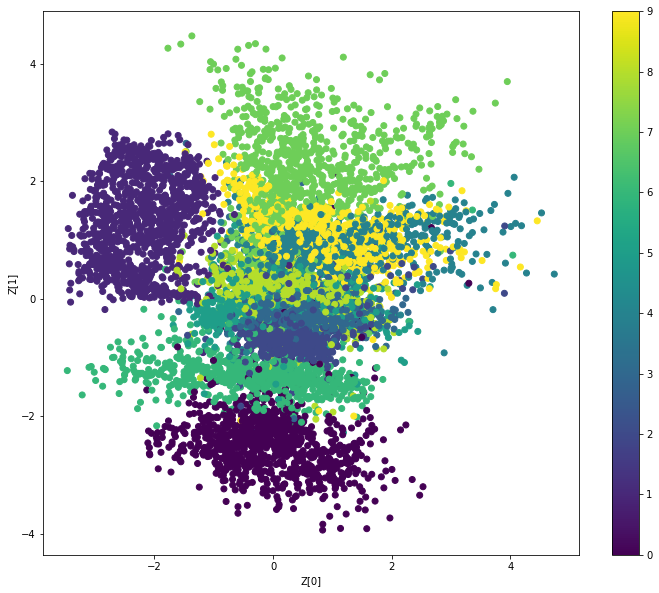

In [9]:
z_test, _, _ = encoder.predict(x_test_data, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test_data)
plt.colorbar()
plt.xlabel("Z[0]")
plt.ylabel("Z[1]")
plt.savefig("VAE")
plt.set_cmap('viridis')
plt.show()


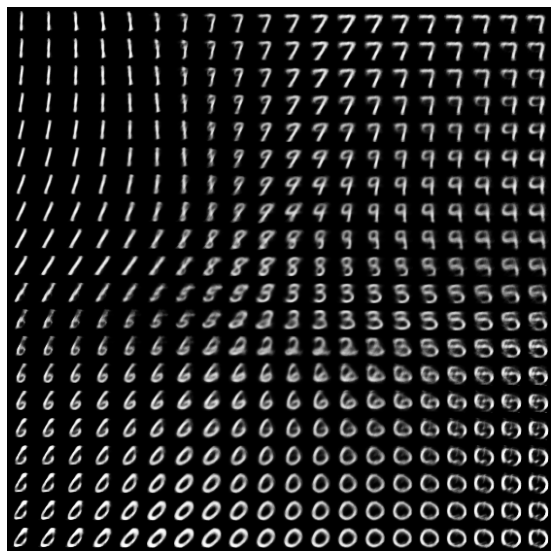

In [10]:
n = 20
digit_num = 28
latent_dim=latent_node
figure = np.zeros((digit_num * n, digit_num * n))
axis_x = np.linspace(-3, 3, n)
axis_y = np.linspace(-3, 3, n)[::-1]    
for i, yi in enumerate(axis_y):
    for j, xi in enumerate(axis_x):
        if(latent_dim == 2):
            latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
        else:
            latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
        input_decoded = decoder.predict(latent_sample)
        digit = input_decoded[0].reshape(digit_num, digit_num)
        figure[i * digit_num: (i + 1) * digit_num,
                j * digit_num: (j + 1) * digit_num] = digit
    
plt.figure(figsize=(10, 10))
i_range = digit_num // 2
j_range = (n - 1) * digit_num + i_range + 1
pixel_range = np.arange(i_range, j_range, digit_num)
sample_range_x = np.round(axis_x, 1)
sample_range_y = np.round(axis_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.imshow(figure)
plt.axis('off')
plt.savefig("VAE_Output")
plt.gray()

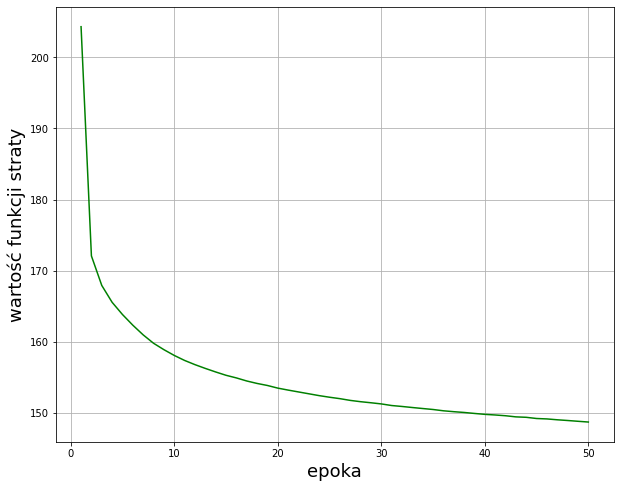

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot([x+1 for x in trained_model.epoch], trained_model.history['loss'], 'g')
plt.ylabel("wartość funkcji straty", fontsize=18)
plt.xlabel("epoka", fontsize=18)
plt.grid(True)
plt.show()